In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
import rasterio as rio
import rasterstats 
from rasterio.plot import show
import os
from shapely.geometry import Polygon, mapping
from rasterio.mask import mask
import seaborn as sns
from geopy.distance import geodesic

In [11]:
# reading shape files and mapping the route 
def read_shape(shapefile, route):
    """
    Reads shapefile and selects desired route.
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    route: route number (integer)
        
    Returns
    -------
    da: New shapefile of desired route only
    map: Interactive map of desired route
    
    """
    dat = gpd.read_file(shapefile)
    da = dat[dat['ROUTE_NUM'] == route]
    da.to_file("da.shp")
    
    points = folium.GeoJson(da.to_json())
    map = folium.Map(location = [47.6, -122.3], zoom_start = 12).add_child(points)
    
    return(da, map)
    
# reading raster files and extract elevation 
def extract_elev(shapefile, route, rasterfile):
    """
    Reads raster file and extracts elevation.
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    route: route number (integer)
    rasterfile: elevation data raster file (.tif file)
    
    Returns
    -------
    elev_meter: elevations values along the route in meters
    
    """
    da, map = read_shape(shapefile, route)
    raw_elev = pd.DataFrame(rasterstats.gen_point_query(da, rasterfile))
    elev = [x for x in raw_elev.iloc[0,:] if x is not None] 
    print('The number of points: {}' .format(len(elev)))
    elev_meter = np.array(elev) * 0.3048
    return(elev_meter)


# extracting points from linestring 
def extract_point(shapefile, route):
    """
    Extracts points from linestring.
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    route: route number (integer)
    
    Returns
    -------
    coord: Coordinates of points along line
    """
    da, map = read_shape(shapefile, route)
    geoms = da.geometry.values # list of shapely geometries
    geometry = geoms[0] # shapely geometry
    geoms = [mapping(geoms[0])]
    ge = np.array(geoms[0]['coordinates'])[:,[0,1]]

    coord = []
    for i in range(len(ge)):
            coord.append([ge[i][1], ge[i][0]])

    return(coord)


# map points 
def map_point(shapefile):
    """
    Plots points on interactive map
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    
    Returns
    -------
    map: Interactive map with route points
    
    """
    coord = extract_point(shapefile, route)
    loca = pd.DataFrame(np.array(coord)).values.tolist()

    map = folium.Map(location=[47.6, -122.3], zoom_start=12)
    for point in range(0, len(loca)):
        folium.Marker(loca[point]).add_to(map)
    
    return(map)


# distance measure 
def dist_measure(shapefile, route):
    """
    Measures distance of points along the route
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    route: route number (integer)
    
    Returns
    -------
    dist: Total route distance value for points along the route
    
    """
    coord = extract_point(shapefile, route)
    dis = []
    for i in range(len(coord)-1):
        dis.append(geodesic(coord[i],coord[i+1]).m)

    distnt = np.insert(dis, 0, 0)
    dist = np.cumsum(distnt)
    
    return(dist)

# route plots 
def profile_plot(shapefile, route, rasterfile):
    """
    Plots route metrics
    
    Parameters
    ----------
    shapefile: route geospatial data (.shp file)
    route: route number (integer)
    rasterfile: elevation data raster file (.tif file)
    
    Returns
    -------
    Plots
    
    """
    dist = dist_measure(shapefile, route)
    elev = extract_elev(shapefile, route, rasterfile)
    
    plt.figure(figsize=(18,5))
    
    tem = pd.DataFrame({'elev': elev, 'dist':dist})
    plt.plot(tem['dist'], tem['elev'], label= 'elevation')
    plt.plot(tem['dist'], np.insert(np.diff(elev), 0,0), label= 'stress index')
    plt.ylabel('Elevation (meter)')
    plt.xlabel('Plain distance (meter)')
    plt.legend()
    
    return()

In [ ]:
read_shape()

C:\users\erica\miniconda3\envs\route_dynamics\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():
C:\users\erica\miniconda3\envs\route_dynamics\lib\site-packages\geopandas\io\file.py:108: FionaDeprecationWarning: Use fiona.Env() instead.
  with fiona.drivers():


The number of points: 208


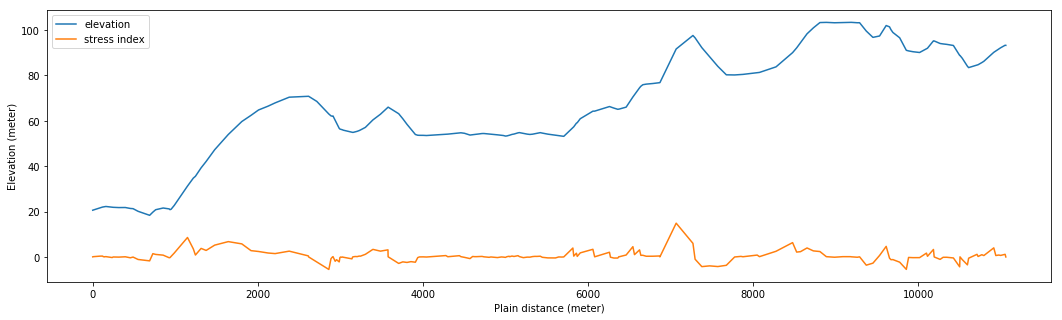

In [6]:
_=profile_plot('six_routes.shp', 45, 'seattle_dtm.tif')


## Test Functions

In [19]:
def read_shape_test():
   
    shapefile = 'six_routes.shp'
    route = 45
    
    assert type(read_shape(shapefile, route)[0]) == geopandas.geodataframe.GeoDataFrame
    assert type(read_shape(shapefile, route)[1]) == folium.folium.Map
    
    return

In [ ]:
def extract_elev_test():
    
    